In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from keras.utils import np_utils
from keras.layers import TextVectorization
import keras.layers as l
import tensorflow as tf
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText
from gensim.test.utils import datapath

from keras.models import Sequential

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

mc = ModelCheckpoint(
    'lol.h5',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1,
)

es = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=8,
    mode='auto'
)

rlr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_delta=0.001,
    verbose=1, 
    mode='auto'
)

callbacks = [mc, es, rlr]

def split_dataset(df):
    train, test, ytrain, ytest = train_test_split(df['item_name'], df['category'], test_size=0.2, random_state=88)

    return train, test, ytrain, ytest
    

def create_one_hot_labels(Y_train, Y_test, labels):
    encoder = LabelEncoder()
    encoder.fit(labels)

    Y_train = encoder.transform(Y_train)
    Y_test = encoder.transform(Y_test)

    n_classes = np.max(Y_train) + 1

    Y_train = np_utils.to_categorical(Y_train, n_classes)
    Y_test = np_utils.to_categorical(Y_test, n_classes)

    return Y_train, Y_test, n_classes


def get_max_len(df):
    idx = df['item_name'].str.len().idxmax()
    print(idx)

    max_len = len(df["item_name"][idx])

    if max_len > 450:
        max_len = 500
    else:
        max_len += 50

    return max_len


def get_vectors(df, X_train, X_test, max_len):
    vectorizer = TextVectorization(output_sequence_length=max_len)

    vectorizer.adapt(df['item_name'])

    vocab = vectorizer.get_vocabulary()

    word_index = dict(zip(vocab, range(len(vocab))))

    X_train = vectorizer(X_train)
    X_test = vectorizer(X_test)

    return X_train, X_test, vocab, word_index


def get_embedding_matrix(vocab, word_index):
    n_tokens = len(vocab) + 2
    embedding_dim = 100
    hits = 0
    misses = 0

    glove_matrix = np.zeros((n_tokens, embedding_dim))

    for word, i in word_index.items():
        try:
            embedding_vector = glove.vectors[glove.stoi[word]]

            # If our word is in GloVE, then get the embedding vector
            if embedding_vector is not None:
                glove_matrix[i] = embedding_vector
                hits += 1
            else: # Otherwise assign a random embedding vector
                glove_matrix[i] = np.random.randn(embedding_dim)
                misses += 1
        except:
            glove_matrix[i] = np.random.randn(embedding_dim)
            misses += 1

    print("Converted %d words (%d misses)" % (hits, misses))

    return glove_matrix, n_tokens


def get_embedding_model(matrix, n_tokens, max_len, n_classes, dim=100, lr=0.0003):
    embedding_layer = l.Embedding(
    n_tokens,
    dim,
    input_length=max_len,
    embeddings_initializer=tf.keras.initializers.Constant(matrix),
    trainable=True
    )

    embedding_model = Sequential()
    embedding_model.add(embedding_layer)
    embedding_model.add(l.GlobalMaxPooling1D()) # Turn 2D output into 1D for dense layers

    embedding_model.add(l.Dense(n_classes, activation='softmax'))

    optim = tf.keras.optimizers.Adam(learning_rate=lr)

    embedding_model.compile(
        loss="categorical_crossentropy", optimizer=optim, metrics=['accuracy']
    )

    return embedding_model


def get_model_acc(X_train, X_test, Y_train, Y_test, model, n_epochs=88):
    history = model.fit(X_train, Y_train, batch_size=25, epochs=n_epochs, validation_data=(X_test, Y_test), callbacks=callbacks)
    metrics = [[name, history.history['val_accuracy'][-1], history.history['val_loss'][-1]]]
    
    metrics = pd.DataFrame(metrics, columns=['variation', 'val_accuracy', 'val_loss'])
    return metrics, history


def train_w2v(df):
    train_w2v = df['item_name'].tolist()

    train_w2v = [x.split() for x in train_w2v]

    w2v_embeddings = Word2Vec(train_w2v, vector_size=100, window=5, workers=8, min_count=1)

    return w2v_embeddings


def get_w2v_matrix(vocab, word_index, embeddings):
    n_tokens = len(vocab) + 1
    embedding_dim = 100
    hits = 0
    misses = 0

    matrix = np.zeros((n_tokens, embedding_dim))

    for word, i in word_index.items():
        try:
            embedding_vector = embeddings.wv[word]

            # If our word is in GloVE, then get the embedding vector
            if embedding_vector is not None:
                matrix[i] = embedding_vector
                hits += 1
            else: # Otherwise assign a random embedding vector
                matrix[i] = np.random.randn(embedding_dim)
                misses += 1
        except:
            matrix[i] = np.random.randn(embedding_dim)
            misses += 1

    print("Converted %d words (%d misses)" % (hits, misses))

    return matrix, n_tokens


def train_ft(df):
    cor_path = datapath("lee_background.cor")
    ft = FastText(vector_size=100)

    train_ft = df['item_name'].tolist()

    train_ft = [x.split() for x in train_ft]

    ft.build_vocab(corpus_file=cor_path)

    ft.train(
        corpus_file=cor_path, epochs=ft.epochs,
        total_examples=ft.corpus_count, total_words=ft.corpus_total_words,
    )

    ft.build_vocab(train_ft, update=True)
    ft.train(train_ft, total_examples=len(train_ft), epochs=ft.epochs)

    return ft


def get_ft_matrix(vocab, word_index, ft):
    n_tokens = len(vocab) + 2
    embedding_dim = 100
    hits = 0
    misses = 0

    matrix = np.zeros((n_tokens, embedding_dim))

    for word, i in word_index.items():
        try:
            embedding_vector = ft.wv[word]

            if embedding_vector is not None:
                matrix[i] = embedding_vector
                hits += 1
            else:
                matrix[i] = np.random.randn(embedding_dim)
                misses += 1
        except Exception as e:
            matrix[i] = np.random.randn(embedding_dim)
            print(e)
            misses += 1

    print("Converted %d words (%d misses)" % (hits, misses))

    return matrix, n_tokens

Get data

In [2]:
import pandas as pd

amazon_data = pd.read_csv("../cleaned/amazon-cleaned.csv",index_col=0)
amazon_labels = amazon_data.category.unique()

shopmania_data = pd.read_csv("../cleaned/shopmania-cleaned.csv", index_col=0)
shopmania_labels = shopmania_data.category.unique()

custom_data = pd.read_csv("../cleaned/custom-cleaned.csv", names=["store_name", "item_name", "category"])
custom_labels = custom_data.category.unique()

datasets = {'amazon': [amazon_data.copy(), amazon_labels], 'shopmania': [shopmania_data.copy(), shopmania_labels], 'custom': [custom_data.copy(), custom_labels]}

Models, experiments

In [3]:
histories = []

In [4]:
from time import process_time

In [5]:
from torchtext.vocab import GloVe

glove = GloVe(name='6B', dim=100)

#ft = FastText('simple')

c:\Users\grace\.conda\envs\FYP\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
results = []

In [7]:
import matplotlib.pyplot as plt
def train_val_graph(history, metric, name):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])

    plt.title(f'History of {metric} over epochs ({name} dataset)')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(['training '+metric, 'validation '+metric])

    plt.show()

# Word2Vec

In [8]:
def run_w2v(df, labels):

    df['item_name'] = df['item_name'].astype(str)

    X_train, X_test, Y_train, Y_test = split_dataset(df)

    Y_train, Y_test, n_classes = create_one_hot_labels(Y_train, Y_test, labels)

    max_len = get_max_len(df)

    X_train, X_test, vocab, word_index = get_vectors(df, X_train, X_test, max_len)

    w2v_embeddings = train_w2v(df)

    w2v_matrix, n_tokens = get_w2v_matrix(vocab, word_index, w2v_embeddings)

    w2v_model = get_embedding_model(w2v_matrix, n_tokens, max_len, n_classes)
    
    metrics = get_model_acc(X_train, X_test, Y_train, Y_test, w2v_model)
    
    return metrics

9834
Converted 17893 words (2 misses)
Epoch 1/88
320/320 [==============================] - 3s 6ms/step - loss: 4.6297 - accuracy: 0.0282 - val_loss: 4.4411 - val_accuracy: 0.0540 - lr: 3.0000e-04
Epoch 2/88
320/320 [==============================] - 2s 6ms/step - loss: 4.3288 - accuracy: 0.0764 - val_loss: 4.2304 - val_accuracy: 0.0980 - lr: 3.0000e-04
Epoch 3/88
320/320 [==============================] - 2s 6ms/step - loss: 4.1157 - accuracy: 0.1414 - val_loss: 4.0288 - val_accuracy: 0.1645 - lr: 3.0000e-04
Epoch 4/88
320/320 [==============================] - 2s 6ms/step - loss: 3.8983 - accuracy: 0.2296 - val_loss: 3.8164 - val_accuracy: 0.2370 - lr: 3.0000e-04
Epoch 5/88
320/320 [==============================] - 2s 6ms/step - loss: 3.6751 - accuracy: 0.3080 - val_loss: 3.6084 - val_accuracy: 0.3105 - lr: 3.0000e-04
Epoch 6/88
320/320 [==============================] - 2s 6ms/step - loss: 3.4470 - accuracy: 0.3907 - val_loss: 3.4030 - val_accuracy: 0.3495 - lr: 3.0000e-04
Epoch 7/

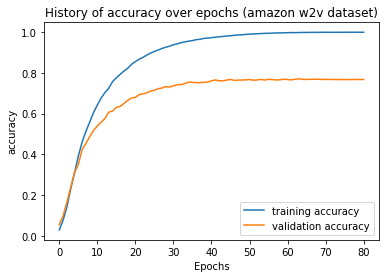

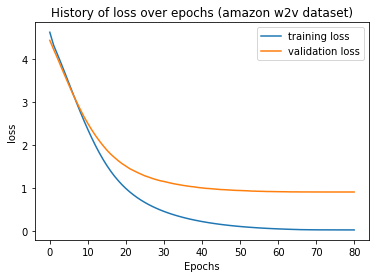

Time taken to process amazon w2v dataset: 3.06m
7412
Converted 11497 words (2 misses)
Epoch 1/88
359/359 [==============================] - 1s 3ms/step - loss: 5.0165 - accuracy: 0.0167 - val_loss: 4.7922 - val_accuracy: 0.0370 - lr: 3.0000e-04
Epoch 2/88
359/359 [==============================] - 1s 3ms/step - loss: 4.6863 - accuracy: 0.0530 - val_loss: 4.6142 - val_accuracy: 0.0807 - lr: 3.0000e-04
Epoch 3/88
359/359 [==============================] - 1s 3ms/step - loss: 4.5039 - accuracy: 0.1108 - val_loss: 4.4571 - val_accuracy: 0.1173 - lr: 3.0000e-04
Epoch 4/88
359/359 [==============================] - 1s 3ms/step - loss: 4.3335 - accuracy: 0.1486 - val_loss: 4.3112 - val_accuracy: 0.1343 - lr: 3.0000e-04
Epoch 5/88
359/359 [==============================] - 1s 2ms/step - loss: 4.1652 - accuracy: 0.1918 - val_loss: 4.1703 - val_accuracy: 0.1829 - lr: 3.0000e-04
Epoch 6/88
359/359 [==============================] - 1s 2ms/step - loss: 3.9984 - accuracy: 0.2509 - val_loss: 4.0330 

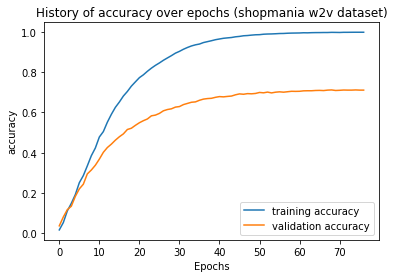

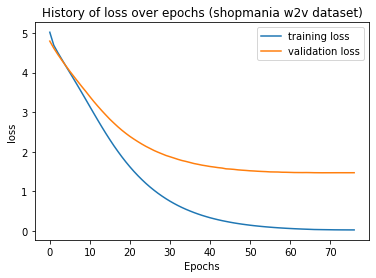

Time taken to process shopmania w2v dataset: 2.13m
567.0
Converted 643 words (3 misses)
Epoch 1/88
22/22 [==============================] - 0s 7ms/step - loss: 2.6866 - accuracy: 0.1540 - val_loss: 2.6634 - val_accuracy: 0.4924 - lr: 3.0000e-04
Epoch 2/88
22/22 [==============================] - 0s 3ms/step - loss: 2.4288 - accuracy: 0.5285 - val_loss: 2.4471 - val_accuracy: 0.4924 - lr: 3.0000e-04
Epoch 3/88
22/22 [==============================] - 0s 3ms/step - loss: 2.2219 - accuracy: 0.5285 - val_loss: 2.2854 - val_accuracy: 0.4924 - lr: 3.0000e-04
Epoch 4/88
22/22 [==============================] - 0s 3ms/step - loss: 2.0722 - accuracy: 0.5285 - val_loss: 2.1656 - val_accuracy: 0.4924 - lr: 3.0000e-04
Epoch 5/88
22/22 [==============================] - 0s 3ms/step - loss: 1.9555 - accuracy: 0.5285 - val_loss: 2.0735 - val_accuracy: 0.4924 - lr: 3.0000e-04
Epoch 6/88
22/22 [==============================] - 0s 3ms/step - loss: 1.8673 - accuracy: 0.5285 - val_loss: 2.0005 - val_accu

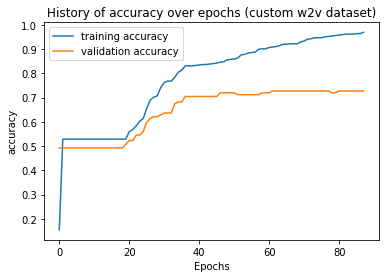

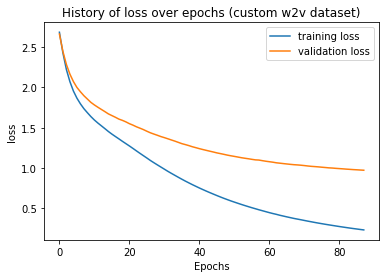

Time taken to process custom w2v dataset: 0.19m


In [9]:
for key, dataset in datasets.items():
    name = key + ' w2v'

    start = process_time()

    metrics, history = run_w2v(dataset[0], dataset[1])
    histories.append(history)

    train_val_graph(history, "accuracy", name)
    train_val_graph(history, "loss", name)

    stop = process_time()

    print(f"Time taken to process {name} dataset: {(stop-start)/60:.2f}m")
    results.append([name, metrics])

# GloVe

In [10]:
def run_glove(df, labels):

    df['item_name'] = df['item_name'].astype(str)

    X_train, X_test, Y_train, Y_test = split_dataset(df)

    Y_train, Y_test, n_classes = create_one_hot_labels(Y_train, Y_test, labels)

    max_len = get_max_len(df)

    X_train, X_test, vocab, word_index = get_vectors(df, X_train, X_test, max_len)

    glove_matrix, n_tokens = get_embedding_matrix(vocab, word_index)

    glove_model = get_embedding_model(glove_matrix, n_tokens, max_len, n_classes)
    
    metrics, history = get_model_acc(X_train, X_test, Y_train, Y_test, glove_model)
    
    return metrics, history

9834
Converted 7392 words (10503 misses)
Epoch 1/88
320/320 [==============================] - 1s 3ms/step - loss: 4.8176 - accuracy: 0.0144 - val_loss: 4.6053 - val_accuracy: 0.0230 - lr: 3.0000e-04
Epoch 2/88
320/320 [==============================] - 1s 3ms/step - loss: 4.5487 - accuracy: 0.0299 - val_loss: 4.5049 - val_accuracy: 0.0390 - lr: 3.0000e-04
Epoch 3/88
320/320 [==============================] - 1s 2ms/step - loss: 4.4215 - accuracy: 0.0556 - val_loss: 4.3959 - val_accuracy: 0.0695 - lr: 3.0000e-04
Epoch 4/88
320/320 [==============================] - 1s 2ms/step - loss: 4.2893 - accuracy: 0.0941 - val_loss: 4.2808 - val_accuracy: 0.1135 - lr: 3.0000e-04
Epoch 5/88
320/320 [==============================] - 1s 3ms/step - loss: 4.1569 - accuracy: 0.1414 - val_loss: 4.1773 - val_accuracy: 0.1505 - lr: 3.0000e-04
Epoch 6/88
320/320 [==============================] - 1s 3ms/step - loss: 4.0211 - accuracy: 0.1970 - val_loss: 4.0673 - val_accuracy: 0.1885 - lr: 3.0000e-04
Epoch

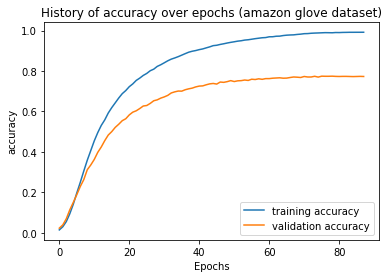

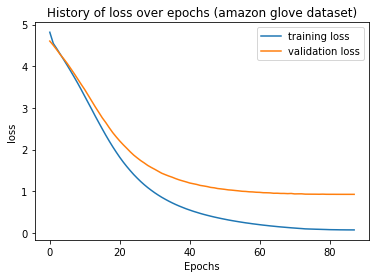

Time taken to process amazon glove dataset: 1.86m
7412
Converted 6945 words (4554 misses)
Epoch 1/88
359/359 [==============================] - 1s 3ms/step - loss: 5.0769 - accuracy: 0.0130 - val_loss: 4.9058 - val_accuracy: 0.0134 - lr: 3.0000e-04
Epoch 2/88
359/359 [==============================] - 1s 3ms/step - loss: 4.8017 - accuracy: 0.0312 - val_loss: 4.7700 - val_accuracy: 0.0558 - lr: 3.0000e-04
Epoch 3/88
359/359 [==============================] - 1s 3ms/step - loss: 4.6426 - accuracy: 0.0911 - val_loss: 4.6273 - val_accuracy: 0.1173 - lr: 3.0000e-04
Epoch 4/88
359/359 [==============================] - 1s 3ms/step - loss: 4.4811 - accuracy: 0.1597 - val_loss: 4.4860 - val_accuracy: 0.1637 - lr: 3.0000e-04
Epoch 5/88
359/359 [==============================] - 1s 3ms/step - loss: 4.3157 - accuracy: 0.2252 - val_loss: 4.3461 - val_accuracy: 0.2221 - lr: 3.0000e-04
Epoch 6/88
359/359 [==============================] - 1s 3ms/step - loss: 4.1466 - accuracy: 0.2702 - val_loss: 4.2

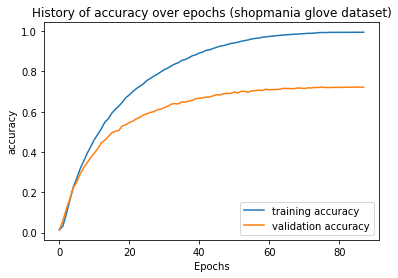

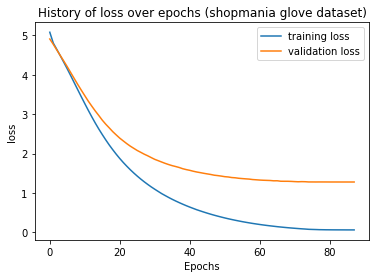

Time taken to process shopmania glove dataset: 2.43m
567.0
Converted 480 words (166 misses)
Epoch 1/88
22/22 [==============================] - 0s 6ms/step - loss: 2.5504 - accuracy: 0.2148 - val_loss: 2.4265 - val_accuracy: 0.2273 - lr: 3.0000e-04
Epoch 2/88
22/22 [==============================] - 0s 3ms/step - loss: 2.1691 - accuracy: 0.3897 - val_loss: 2.1571 - val_accuracy: 0.3864 - lr: 3.0000e-04
Epoch 3/88
22/22 [==============================] - 0s 4ms/step - loss: 1.9411 - accuracy: 0.4677 - val_loss: 2.0199 - val_accuracy: 0.4318 - lr: 3.0000e-04
Epoch 4/88
22/22 [==============================] - 0s 3ms/step - loss: 1.8124 - accuracy: 0.4943 - val_loss: 1.9476 - val_accuracy: 0.4470 - lr: 3.0000e-04
Epoch 5/88
22/22 [==============================] - 0s 3ms/step - loss: 1.7296 - accuracy: 0.5114 - val_loss: 1.8980 - val_accuracy: 0.4697 - lr: 3.0000e-04
Epoch 6/88
22/22 [==============================] - 0s 3ms/step - loss: 1.6725 - accuracy: 0.5152 - val_loss: 1.8698 - val_

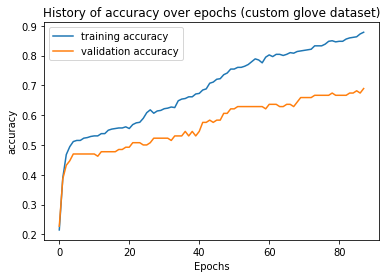

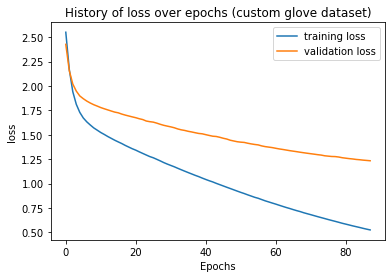

Time taken to process custom glove dataset: 0.17m


In [11]:
for key, dataset in datasets.items():
    name = key + " glove"

    start = process_time()

    metrics, history = run_glove(dataset[0], dataset[1])
    histories.append(history)

    train_val_graph(history, "accuracy", name)
    train_val_graph(history, "loss", name)

    stop = process_time()

    print(f"Time taken to process {name} dataset: {(stop-start)/60:.2f}m")
    results.append([name, metrics])

# fastText

In [12]:
def run_ft(df, labels):

    df['item_name'] = df['item_name'].astype(str)

    X_train, X_test, Y_train, Y_test = split_dataset(df)

    Y_train, Y_test, n_classes = create_one_hot_labels(Y_train, Y_test, labels)

    max_len = get_max_len(df)

    X_train, X_test, vocab, word_index = get_vectors(df, X_train, X_test, max_len)

    ft_embeddings = train_ft(df)

    ft_matrix, n_tokens = get_ft_matrix(vocab, word_index, ft_embeddings)

    ft_model = get_embedding_model(ft_matrix, n_tokens, max_len, n_classes)
    
    metrics = get_model_acc(X_train, X_test, Y_train, Y_test, ft_model)
    
    return metrics

9834
Converted 17895 words (0 misses)
Epoch 1/88
320/320 [==============================] - 1s 4ms/step - loss: 4.5866 - accuracy: 0.0231 - val_loss: 4.4660 - val_accuracy: 0.0305 - lr: 3.0000e-04
Epoch 2/88
320/320 [==============================] - 1s 2ms/step - loss: 4.3662 - accuracy: 0.0625 - val_loss: 4.2728 - val_accuracy: 0.0905 - lr: 3.0000e-04
Epoch 3/88
320/320 [==============================] - 1s 2ms/step - loss: 4.1552 - accuracy: 0.1569 - val_loss: 4.0636 - val_accuracy: 0.1700 - lr: 3.0000e-04
Epoch 4/88
320/320 [==============================] - 1s 2ms/step - loss: 3.9300 - accuracy: 0.2606 - val_loss: 3.8483 - val_accuracy: 0.2520 - lr: 3.0000e-04
Epoch 5/88
320/320 [==============================] - 1s 2ms/step - loss: 3.6982 - accuracy: 0.3481 - val_loss: 3.6350 - val_accuracy: 0.3240 - lr: 3.0000e-04
Epoch 6/88
320/320 [==============================] - 1s 2ms/step - loss: 3.4635 - accuracy: 0.4286 - val_loss: 3.4244 - val_accuracy: 0.3885 - lr: 3.0000e-04
Epoch 7/

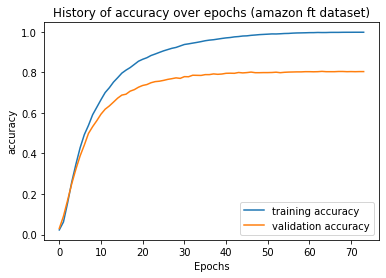

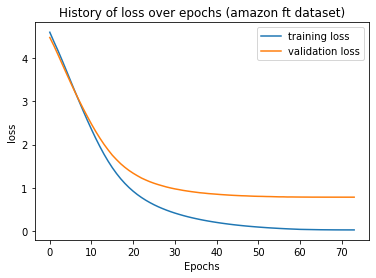

7412
Converted 11499 words (0 misses)
Epoch 1/88
359/359 [==============================] - 1s 3ms/step - loss: 5.0709 - accuracy: 0.0105 - val_loss: 4.9365 - val_accuracy: 0.0076 - lr: 3.0000e-04
Epoch 2/88
359/359 [==============================] - 1s 3ms/step - loss: 4.8729 - accuracy: 0.0213 - val_loss: 4.8518 - val_accuracy: 0.0366 - lr: 3.0000e-04
Epoch 3/88
359/359 [==============================] - 1s 3ms/step - loss: 4.7854 - accuracy: 0.0652 - val_loss: 4.7739 - val_accuracy: 0.0879 - lr: 3.0000e-04
Epoch 4/88
359/359 [==============================] - 1s 3ms/step - loss: 4.6827 - accuracy: 0.1293 - val_loss: 4.6707 - val_accuracy: 0.1401 - lr: 3.0000e-04
Epoch 5/88
359/359 [==============================] - 1s 3ms/step - loss: 4.5505 - accuracy: 0.1979 - val_loss: 4.5438 - val_accuracy: 0.2007 - lr: 3.0000e-04
Epoch 6/88
359/359 [==============================] - 1s 3ms/step - loss: 4.3909 - accuracy: 0.2630 - val_loss: 4.3922 - val_accuracy: 0.2413 - lr: 3.0000e-04
Epoch 7/

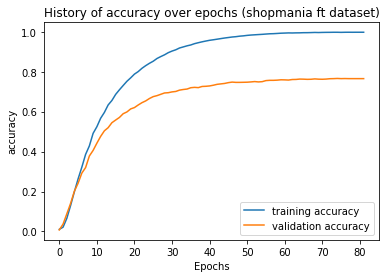

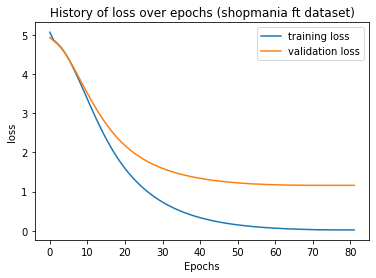

567.0
Converted 646 words (0 misses)
Epoch 1/88
22/22 [==============================] - 0s 7ms/step - loss: 2.8927 - accuracy: 0.0171 - val_loss: 2.8433 - val_accuracy: 0.0455 - lr: 3.0000e-04
Epoch 2/88
22/22 [==============================] - 0s 3ms/step - loss: 2.7991 - accuracy: 0.0856 - val_loss: 2.7558 - val_accuracy: 0.0985 - lr: 3.0000e-04
Epoch 3/88
22/22 [==============================] - 0s 3ms/step - loss: 2.7006 - accuracy: 0.3669 - val_loss: 2.6632 - val_accuracy: 0.4470 - lr: 3.0000e-04
Epoch 4/88
22/22 [==============================] - 0s 3ms/step - loss: 2.5975 - accuracy: 0.5057 - val_loss: 2.5651 - val_accuracy: 0.4848 - lr: 3.0000e-04
Epoch 5/88
22/22 [==============================] - 0s 3ms/step - loss: 2.4914 - accuracy: 0.5285 - val_loss: 2.4664 - val_accuracy: 0.4924 - lr: 3.0000e-04
Epoch 6/88
22/22 [==============================] - 0s 3ms/step - loss: 2.3856 - accuracy: 0.5285 - val_loss: 2.3756 - val_accuracy: 0.4924 - lr: 3.0000e-04
Epoch 7/88
22/22 [===

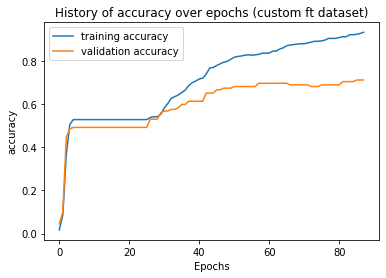

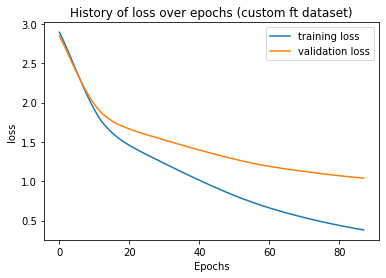

In [13]:
for key, dataset in datasets.items():
    name = key + " ft"

    metrics, history = run_ft(dataset[0], dataset[1])
    histories.append(history)

    train_val_graph(history, "accuracy", name)
    train_val_graph(history, "loss", name)

    results.append([name, metrics])

# TextCNN

In [14]:
def get_textcnn_model(matrix, n_tokens, max_len, n_classes, dim=100):
    inputs = tf.keras.Input(shape=(max_len,))

    embedding_layer = l.Embedding(
        n_tokens,
        dim,
        input_length=max_len,
        embeddings_initializer=tf.keras.initializers.Constant(matrix),
        trainable = True
    )(inputs)

    reshape = l.Reshape((max_len, 100, 1))(embedding_layer)

    conv_0 = l.Conv2D(100, kernel_size=(3,100), activation='relu')(reshape)
    conv_1 = l.Conv2D(100, kernel_size=(4,100), activation='relu')(reshape)
    conv_2 = l.Conv2D(100, kernel_size=(5,100), activation='relu')(reshape)

    maxpool_0 = l.MaxPooling2D(pool_size=(max_len - 3 + 1, 1))(conv_0)
    maxpool_1 = l.MaxPooling2D(pool_size=(max_len - 4 + 1, 1))(conv_1)
    maxpool_2 = l.MaxPooling2D(pool_size=(max_len - 5 + 1, 1))(conv_2)

    concatenate = l.Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])

    flatten = l.Flatten()(concatenate)

    dropout = l.Dropout(0.5)(flatten)

    output = l.Dense(n_classes, activation='softmax')(dropout)

    embedding_model = tf.keras.Model(inputs=inputs, outputs=output)

    optim = tf.keras.optimizers.Adam()

    embedding_model.compile(
        loss="categorical_crossentropy", optimizer=optim, metrics=['accuracy']
    )

    return embedding_model

In [15]:
def run_textcnn(df, labels):
    df['item_name'] = df['item_name'].astype(str)

    X_train, X_test, Y_train, Y_test = split_dataset(df)

    Y_train, Y_test, n_classes = create_one_hot_labels(Y_train, Y_test, labels)

    max_len = get_max_len(df)

    X_train, X_test, vocab, word_index = get_vectors(df, X_train, X_test, max_len)

    ft_embeddings = train_ft(df)

    ft_matrix, n_tokens = get_ft_matrix(vocab, word_index, ft_embeddings)

    print(n_tokens, max_len)

    ft_model = get_textcnn_model(ft_matrix, n_tokens, max_len, n_classes)
    
    metrics = get_model_acc(X_train, X_test, Y_train, Y_test, ft_model)
    
    return metrics

In [16]:
print(len(datasets['amazon'][0]["item_name"][9834]))

2630


9834
Converted 17895 words (0 misses)
17897 500
Epoch 1/88
320/320 [==============================] - 11s 8ms/step - loss: 4.2073 - accuracy: 0.0483 - val_loss: 3.5346 - val_accuracy: 0.1470 - lr: 0.0010
Epoch 2/88
320/320 [==============================] - 2s 8ms/step - loss: 3.3324 - accuracy: 0.1474 - val_loss: 2.7259 - val_accuracy: 0.3415 - lr: 0.0010
Epoch 3/88
320/320 [==============================] - 2s 8ms/step - loss: 2.6299 - accuracy: 0.2891 - val_loss: 2.0884 - val_accuracy: 0.4750 - lr: 0.0010
Epoch 4/88
320/320 [==============================] - 2s 8ms/step - loss: 2.0485 - accuracy: 0.4401 - val_loss: 1.6654 - val_accuracy: 0.6020 - lr: 0.0010
Epoch 5/88
320/320 [==============================] - 2s 8ms/step - loss: 1.6352 - accuracy: 0.5480 - val_loss: 1.3603 - val_accuracy: 0.6770 - lr: 0.0010
Epoch 6/88
320/320 [==============================] - 2s 8ms/step - loss: 1.3132 - accuracy: 0.6455 - val_loss: 1.1936 - val_accuracy: 0.7095 - lr: 0.0010
Epoch 7/88
320/320 [=

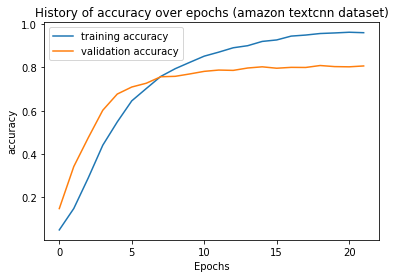

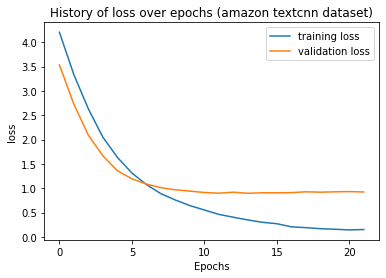

7412
Converted 11499 words (0 misses)
11501 208
Epoch 1/88
359/359 [==============================] - 6s 9ms/step - loss: 4.9310 - accuracy: 0.0175 - val_loss: 4.6716 - val_accuracy: 0.0419 - lr: 0.0010
Epoch 2/88
359/359 [==============================] - 2s 5ms/step - loss: 4.4067 - accuracy: 0.0702 - val_loss: 4.0435 - val_accuracy: 0.1748 - lr: 0.0010
Epoch 3/88
359/359 [==============================] - 2s 5ms/step - loss: 3.8497 - accuracy: 0.1516 - val_loss: 3.5400 - val_accuracy: 0.2498 - lr: 0.0010
Epoch 4/88
359/359 [==============================] - 2s 5ms/step - loss: 3.3404 - accuracy: 0.2347 - val_loss: 3.0991 - val_accuracy: 0.3426 - lr: 0.0010
Epoch 5/88
359/359 [==============================] - 2s 5ms/step - loss: 2.8605 - accuracy: 0.3233 - val_loss: 2.7034 - val_accuracy: 0.4286 - lr: 0.0010
Epoch 6/88
359/359 [==============================] - 2s 5ms/step - loss: 2.4295 - accuracy: 0.4124 - val_loss: 2.3898 - val_accuracy: 0.4964 - lr: 0.0010
Epoch 7/88
359/359 [==

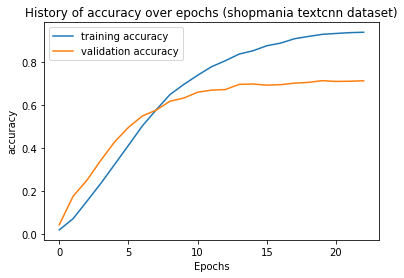

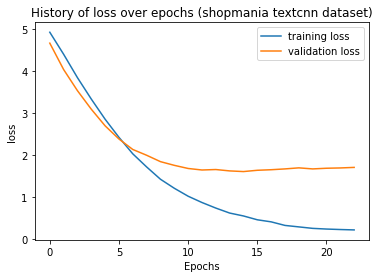

567.0
Converted 646 words (0 misses)
648 109
Epoch 1/88
22/22 [==============================] - 2s 15ms/step - loss: 2.2556 - accuracy: 0.5057 - val_loss: 2.1160 - val_accuracy: 0.4924 - lr: 0.0010
Epoch 2/88
22/22 [==============================] - 0s 6ms/step - loss: 1.8342 - accuracy: 0.5285 - val_loss: 1.9771 - val_accuracy: 0.4924 - lr: 0.0010
Epoch 3/88
22/22 [==============================] - 0s 5ms/step - loss: 1.6750 - accuracy: 0.5285 - val_loss: 1.8683 - val_accuracy: 0.4924 - lr: 0.0010
Epoch 4/88
22/22 [==============================] - 0s 5ms/step - loss: 1.5809 - accuracy: 0.5285 - val_loss: 1.7471 - val_accuracy: 0.4924 - lr: 0.0010
Epoch 5/88
22/22 [==============================] - 0s 5ms/step - loss: 1.4715 - accuracy: 0.5342 - val_loss: 1.6586 - val_accuracy: 0.5530 - lr: 0.0010
Epoch 6/88
22/22 [==============================] - 0s 4ms/step - loss: 1.3417 - accuracy: 0.5817 - val_loss: 1.5966 - val_accuracy: 0.5606 - lr: 0.0010
Epoch 7/88
22/22 [==================

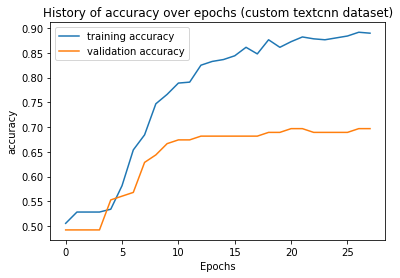

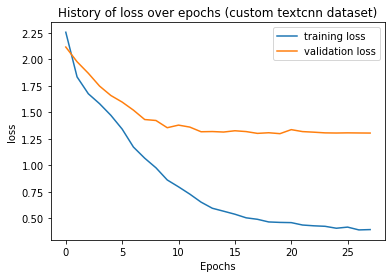

In [17]:
for key, dataset in datasets.items():
    name = key + " textcnn"

    metrics, history = run_textcnn(dataset[0], dataset[1])
    histories.append(history)

    train_val_graph(history, "accuracy", name)
    train_val_graph(history, "loss", name)

# Bi-LSTM

In [18]:
def get_bilstm_model(n_tokens, max_len, n_classes, dim=100):
    model = Sequential()
    
    model.add(l.Embedding(
            n_tokens,
            dim,
            input_length=max_len,
            mask_zero=True
            ))
    model.add(l.Bidirectional(l.LSTM(128, return_sequences=True)))
    model.add(l.Bidirectional(l.LSTM(64)))
    model.add(l.Dense(64, activation='relu'))
    model.add(l.Dense(n_classes, activation='softmax'))

    optim = tf.keras.optimizers.Adam()

    model.compile(
        loss="categorical_crossentropy", optimizer=optim, metrics=['accuracy']
    )

    return model

In [19]:
def run_bilstm(df, labels):
    df['item_name'] = df['item_name'].astype(str)

    X_train, X_test, Y_train, Y_test = split_dataset(df)

    Y_train, Y_test, n_classes = create_one_hot_labels(Y_train, Y_test, labels)

    max_len = get_max_len(df)

    X_train, X_test, vocab, _ = get_vectors(df, X_train, X_test, max_len)

    n_tokens = len(vocab)

    print(n_tokens, max_len)

    ft_model = get_bilstm_model(n_tokens, max_len, n_classes)
    
    metrics = get_model_acc(X_train, X_test, Y_train, Y_test, ft_model)
    
    return metrics

9834
17895 500
Epoch 1/88
320/320 [==============================] - 15s 26ms/step - loss: 3.4934 - accuracy: 0.1561 - val_loss: 2.3671 - val_accuracy: 0.3390 - lr: 0.0010
Epoch 2/88
320/320 [==============================] - 6s 19ms/step - loss: 1.7062 - accuracy: 0.5189 - val_loss: 1.6895 - val_accuracy: 0.5615 - lr: 0.0010
Epoch 3/88
320/320 [==============================] - 6s 19ms/step - loss: 0.8767 - accuracy: 0.7689 - val_loss: 1.4759 - val_accuracy: 0.6565 - lr: 0.0010
Epoch 4/88
320/320 [==============================] - 6s 19ms/step - loss: 0.4792 - accuracy: 0.8777 - val_loss: 1.5242 - val_accuracy: 0.6785 - lr: 0.0010
Epoch 5/88
318/320 [============================>.] - ETA: 0s - loss: 0.3004 - accuracy: 0.9215
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
320/320 [==============================] - 6s 19ms/step - loss: 0.3011 - accuracy: 0.9210 - val_loss: 1.5619 - val_accuracy: 0.6775 - lr: 0.0010
Epoch 6/88
320/320 [=======================

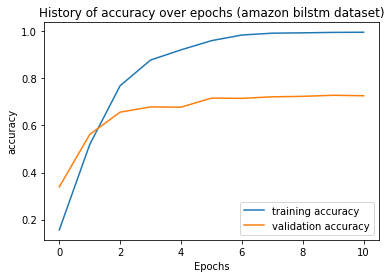

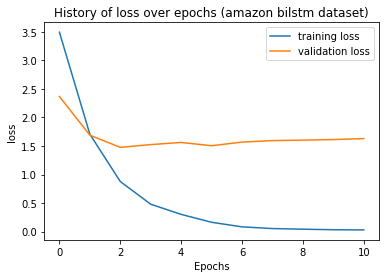

7412
11499 208
Epoch 1/88
359/359 [==============================] - 17s 25ms/step - loss: 4.1865 - accuracy: 0.1092 - val_loss: 3.1660 - val_accuracy: 0.2636 - lr: 0.0010
Epoch 2/88
359/359 [==============================] - 6s 16ms/step - loss: 2.3981 - accuracy: 0.4205 - val_loss: 2.2944 - val_accuracy: 0.4826 - lr: 0.0010
Epoch 3/88
359/359 [==============================] - 6s 16ms/step - loss: 1.4044 - accuracy: 0.6547 - val_loss: 2.0274 - val_accuracy: 0.5669 - lr: 0.0010
Epoch 4/88
359/359 [==============================] - 6s 16ms/step - loss: 0.8460 - accuracy: 0.7947 - val_loss: 2.0534 - val_accuracy: 0.6062 - lr: 0.0010
Epoch 5/88
358/359 [============================>.] - ETA: 0s - loss: 0.5394 - accuracy: 0.8641
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
359/359 [==============================] - 6s 16ms/step - loss: 0.5390 - accuracy: 0.8643 - val_loss: 2.0941 - val_accuracy: 0.6298 - lr: 0.0010
Epoch 6/88
359/359 [=======================

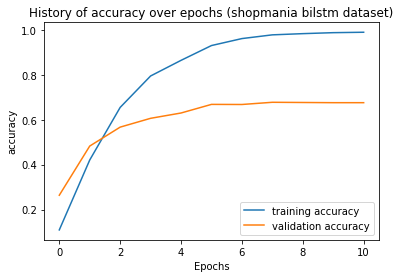

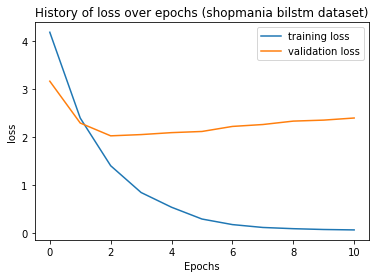

567.0
646 109
Epoch 1/88
22/22 [==============================] - 12s 170ms/step - loss: 2.6992 - accuracy: 0.5000 - val_loss: 2.3698 - val_accuracy: 0.4924 - lr: 0.0010
Epoch 2/88
22/22 [==============================] - 0s 23ms/step - loss: 1.9480 - accuracy: 0.5285 - val_loss: 1.7840 - val_accuracy: 0.4924 - lr: 0.0010
Epoch 3/88
22/22 [==============================] - 0s 14ms/step - loss: 1.3628 - accuracy: 0.5551 - val_loss: 1.4500 - val_accuracy: 0.5682 - lr: 0.0010
Epoch 4/88
22/22 [==============================] - 0s 14ms/step - loss: 0.9856 - accuracy: 0.6597 - val_loss: 1.2773 - val_accuracy: 0.6288 - lr: 0.0010
Epoch 5/88
22/22 [==============================] - 0s 14ms/step - loss: 0.6695 - accuracy: 0.7947 - val_loss: 1.2623 - val_accuracy: 0.7045 - lr: 0.0010
Epoch 6/88
22/22 [==============================] - 0s 14ms/step - loss: 0.4977 - accuracy: 0.8403 - val_loss: 1.3326 - val_accuracy: 0.7045 - lr: 0.0010
Epoch 7/88
21/22 [===========================>..] - ETA: 0s 

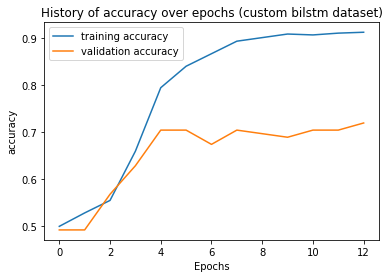

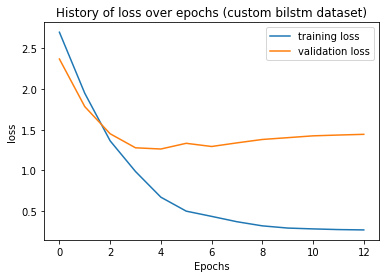

In [20]:
for key, dataset in datasets.items():
    name = key + " bilstm"

    metrics, history = run_bilstm(dataset[0], dataset[1])
    histories.append(history)

    train_val_graph(history, "accuracy", name)
    train_val_graph(history, "loss", name)

# Bi-LSTM with pre-trained embs

In [24]:
def get_embilstm_model(matrix, n_tokens, max_len, n_classes, dim=100, lr=0.0001):
    model = Sequential()
    
    model.add(l.Embedding(
            n_tokens,
            dim,
            input_length=max_len,
            embeddings_initializer=tf.keras.initializers.Constant(matrix),
            trainable=True
            ))
    model.add(l.Bidirectional(l.LSTM(128, return_sequences=True)))
    model.add(l.Bidirectional(l.LSTM(64)))
    model.add(l.Dense(64, activation='relu'))
    model.add(l.Dense(n_classes, activation='softmax'))

    optim = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(
        loss="categorical_crossentropy", optimizer=optim, metrics=['accuracy']
    )

    return model

In [25]:
def run_embilstm(df, labels):
    df['item_name'] = df['item_name'].astype(str)

    X_train, X_test, Y_train, Y_test = split_dataset(df)

    Y_train, Y_test, n_classes = create_one_hot_labels(Y_train, Y_test, labels)

    max_len = get_max_len(df)

    X_train, X_test, vocab, word_index = get_vectors(df, X_train, X_test, max_len)

    ft_embeddings = train_ft(df)

    ft_matrix, n_tokens = get_ft_matrix(vocab, word_index, ft_embeddings)

    print(n_tokens, max_len)

    ft_model = get_embilstm_model(ft_matrix, n_tokens, max_len, n_classes)
    
    metrics = get_model_acc(X_train, X_test, Y_train, Y_test, ft_model, n_epochs=15)
    
    return metrics

9834
Converted 17895 words (0 misses)
17897 500
Epoch 1/15
320/320 [==============================] - 33s 96ms/step - loss: 4.5022 - accuracy: 0.0346 - val_loss: 4.2560 - val_accuracy: 0.0525 - lr: 1.0000e-04
Epoch 2/15
320/320 [==============================] - 29s 92ms/step - loss: 3.9681 - accuracy: 0.0661 - val_loss: 3.7209 - val_accuracy: 0.1015 - lr: 1.0000e-04
Epoch 3/15
320/320 [==============================] - 29s 92ms/step - loss: 3.4819 - accuracy: 0.1331 - val_loss: 3.3024 - val_accuracy: 0.1720 - lr: 1.0000e-04
Epoch 4/15
320/320 [==============================] - 29s 91ms/step - loss: 3.1231 - accuracy: 0.2066 - val_loss: 3.0142 - val_accuracy: 0.2300 - lr: 1.0000e-04
Epoch 5/15
320/320 [==============================] - 29s 91ms/step - loss: 2.8604 - accuracy: 0.2684 - val_loss: 2.8401 - val_accuracy: 0.2610 - lr: 1.0000e-04
Epoch 6/15
320/320 [==============================] - 29s 91ms/step - loss: 2.6348 - accuracy: 0.3160 - val_loss: 2.6564 - val_accuracy: 0.3170 - l

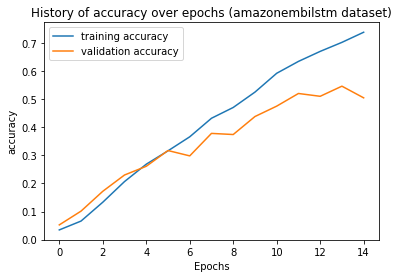

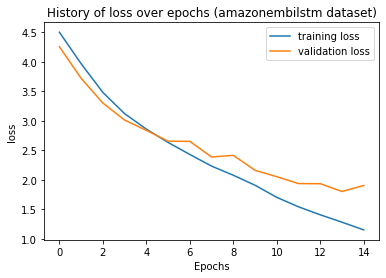

7412
Converted 11499 words (0 misses)
11501 208
Epoch 1/15
359/359 [==============================] - 19s 44ms/step - loss: 5.1363 - accuracy: 0.0080 - val_loss: 4.9870 - val_accuracy: 0.0094 - lr: 1.0000e-04
Epoch 2/15
359/359 [==============================] - 15s 42ms/step - loss: 4.8921 - accuracy: 0.0128 - val_loss: 4.7939 - val_accuracy: 0.0227 - lr: 1.0000e-04
Epoch 3/15
359/359 [==============================] - 15s 42ms/step - loss: 4.6599 - accuracy: 0.0358 - val_loss: 4.5550 - val_accuracy: 0.0424 - lr: 1.0000e-04
Epoch 4/15
359/359 [==============================] - 15s 42ms/step - loss: 4.3946 - accuracy: 0.0627 - val_loss: 4.3492 - val_accuracy: 0.0580 - lr: 1.0000e-04
Epoch 5/15
359/359 [==============================] - 15s 42ms/step - loss: 4.1001 - accuracy: 0.0915 - val_loss: 4.0479 - val_accuracy: 0.0981 - lr: 1.0000e-04
Epoch 6/15
359/359 [==============================] - 15s 42ms/step - loss: 3.8090 - accuracy: 0.1375 - val_loss: 3.8277 - val_accuracy: 0.1436 - l

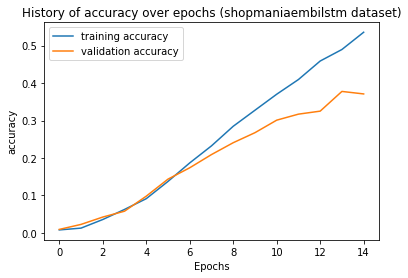

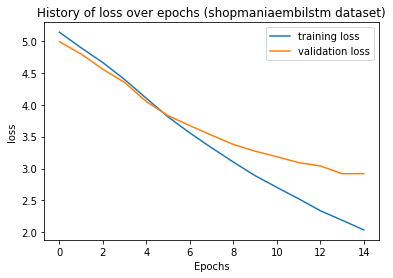

567.0
Converted 646 words (0 misses)
648 109
Epoch 1/15
22/22 [==============================] - 4s 69ms/step - loss: 2.7934 - accuracy: 0.4506 - val_loss: 2.7397 - val_accuracy: 0.4924 - lr: 1.0000e-04
Epoch 2/15
22/22 [==============================] - 1s 26ms/step - loss: 2.6407 - accuracy: 0.5285 - val_loss: 2.4682 - val_accuracy: 0.4924 - lr: 1.0000e-04
Epoch 3/15
22/22 [==============================] - 1s 27ms/step - loss: 2.0721 - accuracy: 0.5285 - val_loss: 1.9201 - val_accuracy: 0.4924 - lr: 1.0000e-04
Epoch 4/15
22/22 [==============================] - 1s 27ms/step - loss: 1.7066 - accuracy: 0.5285 - val_loss: 1.8440 - val_accuracy: 0.4924 - lr: 1.0000e-04
Epoch 5/15
22/22 [==============================] - 1s 26ms/step - loss: 1.6728 - accuracy: 0.5285 - val_loss: 1.8361 - val_accuracy: 0.4924 - lr: 1.0000e-04
Epoch 6/15
22/22 [==============================] - 1s 27ms/step - loss: 1.6622 - accuracy: 0.5285 - val_loss: 1.8334 - val_accuracy: 0.4924 - lr: 1.0000e-04
Epoch 7

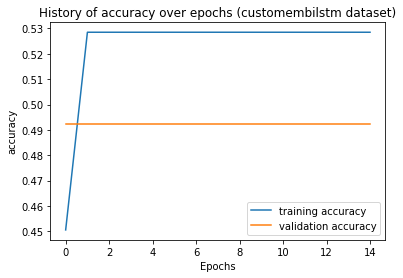

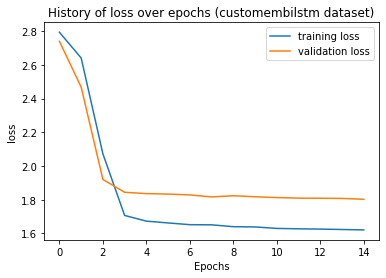

In [26]:
for key, dataset in datasets.items():
    name = key + "embilstm"

    metrics, history = run_embilstm(dataset[0], dataset[1])
    histories.append(history)

    train_val_graph(history, "accuracy", name)
    train_val_graph(history, "loss", name)

# CNN + Bi-LSTM (ft)

In [ ]:
def get_combo_model(matrix, n_tokens, max_len, n_classes, dim=100):
    inputs = tf.keras.Input(shape=(max_len,))

    embedding_layer = l.Embedding(
        n_tokens,
        dim,
        input_length=max_len,
        embeddings_initializer=tf.keras.initializers.Constant(matrix),
        trainable = True
    )(inputs)

    reshape = l.Reshape((max_len, 100, 1))(embedding_layer)

    conv_0 = l.Conv2D(100, kernel_size=(3,100), activation='relu')(reshape)
    conv_1 = l.Conv2D(100, kernel_size=(4,100), activation='relu')(reshape)
    conv_2 = l.Conv2D(100, kernel_size=(5,100), activation='relu')(reshape)

    maxpool_0 = l.MaxPooling2D(pool_size=(max_len - 3 + 1, 1))(conv_0)
    maxpool_1 = l.MaxPooling2D(pool_size=(max_len - 4 + 1, 1))(conv_1)
    maxpool_2 = l.MaxPooling2D(pool_size=(max_len - 5 + 1, 1))(conv_2)

    concatenate = l.Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])

    flatten = l.Flatten()(concatenate)

    reshape = l.Reshape((-1, 300))(flatten)

    lstm1 = l.Bidirectional(l.LSTM(128, return_sequences=True))(reshape)
    dropout2 = l.Dropout(0.2)(lstm1)
    lstm2 = l.Bidirectional(l.LSTM(64))(dropout2)
    dropout3 = l.Dropout(0.2)(lstm2)
    dense = l.Dense(64, activation='relu')(dropout3)
    dropout4 = l.Dropout(0.1)(dense)

    output = l.Dense(n_classes, activation='softmax')(dropout4)

    embedding_model = tf.keras.Model(inputs=inputs, outputs=output)

    optim = tf.keras.optimizers.Adam()

    embedding_model.compile(
        loss="categorical_crossentropy", optimizer=optim, metrics=['accuracy']
    )

    return embedding_model

In [ ]:
def run_combo(df, labels):
    df['item_name'] = df['item_name'].astype(str)

    X_train, X_test, Y_train, Y_test = split_dataset(df)

    Y_train, Y_test, n_classes = create_one_hot_labels(Y_train, Y_test, labels)

    max_len = get_max_len(df)

    X_train, X_test, vocab, word_index = get_vectors(df, X_train, X_test, max_len)

    ft_embeddings = train_ft(df)

    ft_matrix, n_tokens = get_ft_matrix(vocab, word_index, ft_embeddings)

    print(n_tokens, max_len)

    ft_model = get_combo_model(ft_matrix, n_tokens, max_len, n_classes)
    
    metrics = get_model_acc(X_train, X_test, Y_train, Y_test, ft_model)
    
    return metrics
print(len(datasets['amazon'][0]["item_name"][9834]))

2919


9834
Converted 19893 words (0 misses)
19895 500
Epoch 1/30
320/320 [==============================] - 7s 14ms/step - loss: 4.0680 - accuracy: 0.0457 - val_loss: 3.3926 - val_accuracy: 0.0925
Epoch 2/30
320/320 [==============================] - 3s 11ms/step - loss: 3.0755 - accuracy: 0.1445 - val_loss: 2.6657 - val_accuracy: 0.2210
Epoch 3/30
320/320 [==============================] - 3s 11ms/step - loss: 2.3966 - accuracy: 0.2736 - val_loss: 2.2014 - val_accuracy: 0.3400
Epoch 4/30
320/320 [==============================] - 3s 11ms/step - loss: 1.8346 - accuracy: 0.4139 - val_loss: 1.9063 - val_accuracy: 0.4495
Epoch 5/30
320/320 [==============================] - 3s 11ms/step - loss: 1.4587 - accuracy: 0.5309 - val_loss: 1.8121 - val_accuracy: 0.5185
Epoch 6/30
320/320 [==============================] - 3s 11ms/step - loss: 1.1402 - accuracy: 0.6399 - val_loss: 1.6908 - val_accuracy: 0.5655
Epoch 7/30
320/320 [==============================] - 3s 11ms/step - loss: 0.8835 - accuracy: 

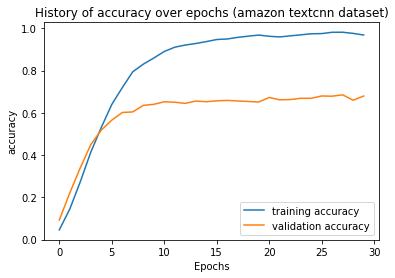

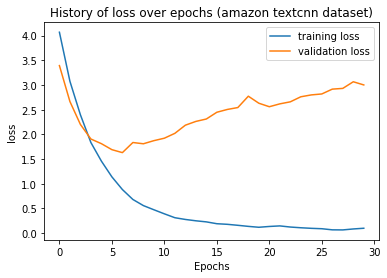

7412
Converted 13203 words (0 misses)
13205 223
Epoch 1/30
359/359 [==============================] - 8s 12ms/step - loss: 4.9455 - accuracy: 0.0109 - val_loss: 4.6056 - val_accuracy: 0.0201
Epoch 2/30
359/359 [==============================] - 3s 9ms/step - loss: 4.2839 - accuracy: 0.0453 - val_loss: 3.9604 - val_accuracy: 0.0852
Epoch 3/30
359/359 [==============================] - 3s 9ms/step - loss: 3.6793 - accuracy: 0.1093 - val_loss: 3.5571 - val_accuracy: 0.1347
Epoch 4/30
359/359 [==============================] - 3s 9ms/step - loss: 3.2221 - accuracy: 0.1609 - val_loss: 3.3792 - val_accuracy: 0.1771
Epoch 5/30
359/359 [==============================] - 3s 9ms/step - loss: 2.8713 - accuracy: 0.2155 - val_loss: 3.1984 - val_accuracy: 0.2270
Epoch 6/30
359/359 [==============================] - 3s 9ms/step - loss: 2.5943 - accuracy: 0.2619 - val_loss: 3.1462 - val_accuracy: 0.2690
Epoch 7/30
359/359 [==============================] - 3s 9ms/step - loss: 2.3496 - accuracy: 0.3104

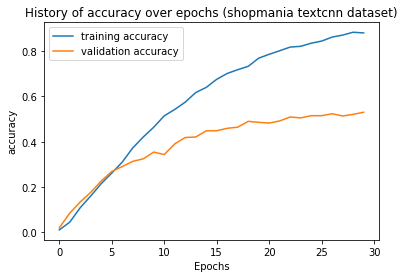

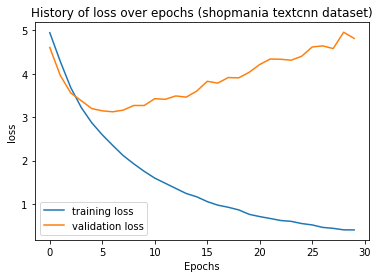

567.0
Converted 697 words (0 misses)
699 111
Epoch 1/30
22/22 [==============================] - 4s 54ms/step - loss: 2.4810 - accuracy: 0.4934 - val_loss: 1.7111 - val_accuracy: 0.5530
Epoch 2/30
22/22 [==============================] - 0s 9ms/step - loss: 1.7663 - accuracy: 0.5123 - val_loss: 1.5899 - val_accuracy: 0.5530
Epoch 3/30
22/22 [==============================] - 0s 9ms/step - loss: 1.7384 - accuracy: 0.5123 - val_loss: 1.5663 - val_accuracy: 0.5530
Epoch 4/30
22/22 [==============================] - 0s 9ms/step - loss: 1.7171 - accuracy: 0.5123 - val_loss: 1.5692 - val_accuracy: 0.5530
Epoch 5/30
22/22 [==============================] - 0s 9ms/step - loss: 1.7371 - accuracy: 0.5066 - val_loss: 1.5494 - val_accuracy: 0.5530
Epoch 6/30
22/22 [==============================] - 0s 9ms/step - loss: 1.6921 - accuracy: 0.5123 - val_loss: 1.5311 - val_accuracy: 0.5530
Epoch 7/30
22/22 [==============================] - 0s 9ms/step - loss: 1.6898 - accuracy: 0.5104 - val_loss: 1.49

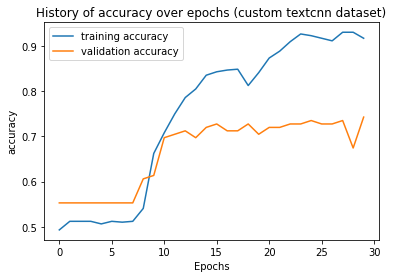

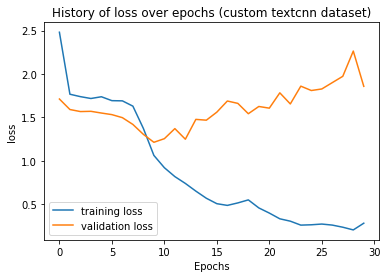

In [ ]:
for key, dataset in datasets.items():
    name = key + " textcnn"

    metrics, history = run_combo(dataset[0], dataset[1])
    histories.append(history)

    train_val_graph(history, "accuracy", name)
    train_val_graph(history, "loss", name)

# Results

In [ ]:
arr = []

for result in results:
    arr.append(result[1].values.tolist()[0])

print(arr)

[['amazon w2v', 0.7559999823570251, 1.0157526731491089], ['shopmania w2v', 0.6944692134857178, 1.4702917337417603], ['custom w2v', 0.8409090638160706, 0.704954981803894], ['amazon glove', 0.7870000004768372, 0.8449316024780273], ['shopmania glove', 0.753345251083374, 1.1587003469467163], ['custom glove', 0.8181818127632141, 0.7687065005302429], ['amazon ft', 0.7960000038146973, 0.8343586921691895], ['shopmania ft', 0.7578055262565613, 1.1647735834121704], ['custom ft', 0.7954545617103577, 0.7521497011184692]]


In [ ]:
results_df = pd.DataFrame(arr, columns=['variation', 'val_accuracy', 'val_loss'])

In [ ]:
results_df

,variation,val_accuracy,val_loss
0,amazon w2v,0.756000,1.015753
1,shopmania w2v,0.694469,1.470292
2,custom w2v,0.840909,0.704955
3,amazon glove,0.787000,0.844932
4,shopmania glove,0.753345,1.158700
5,custom glove,0.818182,0.768707
6,amazon ft,0.796000,0.834359
7,shopmania ft,0.757806,1.164774
8,custom ft,0.795455,0.752150


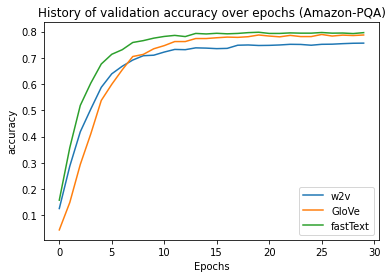

In [ ]:
for history in [histories[0],histories[3],histories[6]]:
    metric = 'accuracy'
    plt.plot(history.history['val_'+metric])

plt.title(f'History of validation {metric} over epochs (Amazon-PQA)')
plt.xlabel("Epochs")
plt.ylabel(metric)
plt.legend([
    'w2v',
    'GloVe',
    'fastText'
    ])

plt.show()

In [ ]:
results_df.to_csv("embeddings.csv")

In [ ]:
results_df = pd.read_csv("embeddings.csv", index_col=0)

In [ ]:
results_df

,variation,val_accuracy,val_loss
0,amazon w2v,0.778000,0.926812
1,shopmania w2v,0.707404,1.393095
2,custom w2v,0.782178,0.677114
3,amazon glove,0.776000,0.923861
4,shopmania glove,0.732382,1.238198
5,custom glove,0.742574,0.932920
6,amazon ft,0.317000,2.910503
7,shopmania ft,0.290812,3.369364
8,custom ft,0.752475,1.720810
